In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dataframe_image as dfi
from datetime import datetime
import scipy
import itertools
import geopandas as gpd
import xarray as xr
import regionmask
import statsmodels.api as sm
import statsmodels.formula.api as smf

/home/sara/.local/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_48360/1413625899.py:8: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (

Data from UEA CRU TS3.10 (1901-2009)

In [3]:
file = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/cru_ts_3_10.1901.2009.tmp.dat.nc"
file2 = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/cru_ts_3_10_01.1901.2009.pre.dat.nc"

file_paths_list =[file,file2]
monthly_forecast=xr.Dataset()

for file in file_paths_list:
        monthly_forecast = xr.merge([monthly_forecast,xr.open_mfdataset(file)], compat='override')

OSError: no files to open

Data on conflict events from ACLED

In [6]:
file = r"C:\Users\PcLaptop\Documents\GitHub\Climate-and-conflict\Datasets\ACLED_1997-01-01-2023-07-18_Somalia.csv"
df = pd.read_csv(file)

Shapefile with administrative boundaries of Somalia

In [7]:
path = r"C:\Users\PcLaptop\Documents\GitHub\Climate-and-conflict\Datasets\som_adm_ocha_itos_20230308_shp\som_admbnda_adm1_ocha_20230308.shp"
states_gdf = gpd.read_file(path) 

Limit the lat-lon and time

In [8]:
def get_aoi(shp, world=True):
    lon_lat = {}
    # Get lat min, max
    aoi_lat = [float(shp.total_bounds[1]), float(shp.total_bounds[3])]
    aoi_lon = [float(shp.total_bounds[0]), float(shp.total_bounds[2])]

    lon_lat["lon"] = aoi_lon
    lon_lat["lat"] = aoi_lat
    return lon_lat

bounds = get_aoi(states_gdf)

In [9]:
start_date = '1901-01-01'
end_date = '2009-12-31'

region = monthly_forecast[["pre",'tmp']].sel(
    time=slice(start_date, end_date),
    lon=slice(bounds["lon"][0], bounds["lon"][1]),
    lat=slice(bounds["lat"][0], bounds["lat"][1]))

In [10]:
region_mask = regionmask.mask_3D_geopandas(states_gdf,
                                         monthly_forecast.lon,
                                         monthly_forecast.lat)

temp_pre = region.where(region_mask)

In [11]:
temp_pre = temp_pre.groupby("time").mean(["lat", "lon"]).to_dataframe().reset_index()

In [12]:
replacement_dict = {0  :  'Awdal',
1    :         'Bakool',
2      :       'Banadir',
3      :         'Bari',
4       :         'Bay',
5        :  'Galgaduud',
6          :      'Gedo',
7          :   'Hiraan',
8   :       'Lower_Juba',
9   :   'Lower_Shabelle',
10  :      'Middle_Juba',
11   : 'Middle_Shabelle',
12    :          'Mudug',
13    :        'Nugaal',
14      :       'Sanaag',
15       :        'Sool',
16        :   'Togdheer',
17   : 'Woqooyi_Galbeed'}

temp_pre['admin1'] = temp_pre['region'].replace(replacement_dict)
df['admin1'] = df['admin1'].str.replace(' ', '_')
temp_pre.drop('region', axis=1, inplace=True)

In [13]:
# Modify event_date column to datetime

df['event_date'] = pd.to_datetime(df['event_date'])
df = df.set_index('event_date') 

In [14]:
conflict = df.groupby([pd.Grouper(freq='M'),"admin1"]).count()
conflict.reset_index(level=[0, 1], inplace=True)
conflict = conflict[['event_date','admin1','year']].rename(columns={'year': 'conflicts','event_date': 'time'})

# Aggregate the datetime objects by month
conf = conflict.groupby([pd.Grouper(key='time', freq='M'),'admin1'])['conflicts'].sum().to_frame()

In [15]:
# Reindex the DataFrame with all dates and districts and fill missing values with 0

dates = conf.index.get_level_values('time').unique()
districts = conf.index.get_level_values('admin1').unique()
all_combinations = pd.MultiIndex.from_product([dates, districts], names=['time', 'admin1'])

conflicts = conf.reindex(all_combinations, fill_value=0).reset_index()    
conflicts = conflicts.sort_values(by=['time', 'admin1'], ascending=[True, True])
conflicts.reset_index(drop=True, inplace=True)

In [16]:
# Add Banadir region with tmp and pre as mean of the neighbouring regions

district1 = 'Lower_Shabelle'  
district2 = 'Middle_Shabelle'  

# Calculate the mean tmp and pre for the neighboring districts
mean_t = temp_pre[(temp_pre['admin1']==district1) | (temp_pre['admin1']==district2)].groupby('time')['tmp'].mean()
mean_p = temp_pre[(temp_pre['admin1']==district1) | (temp_pre['admin1']==district2)].groupby('time')['pre'].mean()

new_data = pd.DataFrame({ 'admin1': 'Banadir', 'tmp': mean_t, 'pre': mean_p}).reset_index()

# Append the new DataFrame to the original DataFrame
df3 = pd.concat([temp_pre, new_data])

temp_pre = df3.sort_values(by=['time', 'admin1'], ascending=[True, True]).reset_index(drop=True)

In [17]:
# Only keep month and year in time column in temp_pre and conflicts

temp_pre['time'] = pd.to_datetime(temp_pre['time']).dt.strftime('%Y-%m-%d')
temp_pre['month'] = temp_pre['time'].str[5:7]
temp_pre['month_year'] = temp_pre['time'].str[:7]
conflicts['time'] = conflicts['time'].dt.strftime('%Y-%m').values

temp_pre = temp_pre[['month_year','admin1','tmp','pre']]
temp_pre = temp_pre.rename(columns={'month_year':'time'})

In [18]:
# Split the dataframe into regions

reg=[]
for admin in temp_pre['admin1'].unique():
    a = temp_pre[temp_pre['admin1']==admin].reset_index(drop=True)
    reg.append(a)

In [19]:
# Calculate the TA (temperature anomaly), PA (precipitation anomaly) and DL (drought lenght) for each region

avg_t = avg_p = std_t = std_p = np.zeros(18)

for i in range(18):

    reg[i]['year'] , reg[i]['month'] = reg[i]['time'].str[:4] , reg[i]['time'].str[5:7]

    # TA
    mean_temp_i , std_temp_i  = reg[i].groupby('month')['tmp'].mean() , reg[i].groupby('month')['tmp'].std()
    reg[i]['avg_temp'] , reg[i]['std_temp']  = reg[i]['month'].map(mean_temp_i) , reg[i]['month'].map(std_temp_i)
    reg[i]['diff_t']= (reg[i]['tmp']-reg[i]['avg_temp'])/reg[i]['std_temp']
    reg[i]['TA'] = (reg[i]['diff_t'].shift(2) + reg[i]['diff_t'].shift(1) + reg[i]['diff_t'])/3

    # PA
    mean_pre_i , std_pre_i  = reg[i].groupby('month')['pre'].mean() , reg[i].groupby('month')['pre'].std()
    reg[i]['avg_pre'] , reg[i]['std_pre']= reg[i]['month'].map(mean_pre_i) , reg[i]['month'].map(std_pre_i)
    reg[i]['diff_p']= (reg[i]['pre']-reg[i]['avg_pre'])/reg[i]['std_pre']
    reg[i]['PA'] = (reg[i]['diff_p'].shift(2) + reg[i]['diff_p'].shift(1) + reg[i]['diff_p'])/3
    
    # DL 
    reg[i]['DL'] = 0
    mask = reg[i]['TA'] > 0
    group_id = (mask != mask.shift()).cumsum()             # Create a group identifier for each consecutive group
    count = reg[i].groupby(group_id).cumcount() + 1        # Calculate the count within each group
    reg[i]['DL'] = np.where(mask, count, 0)                # Assign the count values to the 'DL' column

    reg[i] = reg[i].reset_index()

In [20]:
temp_pre_c = pd.concat([reg[i] for i in range(18)], axis=0)
temp_pre_c = temp_pre_c.dropna()

# Select a subset of the dataframes from 1997-01 to 2009-12

start='1997-01'
end='2009-12'
temp_pre_97_09 = temp_pre_c[(temp_pre_c['time'] >= start) & (temp_pre_c['time'] <= end)]
conflicts_97_09 = conflicts[(conflicts['time'] >= start) & (conflicts['time'] <= end)]

df_c_97_09 = pd.merge(temp_pre_97_09, conflicts_97_09, on=['time','admin1'], how='outer')
df_c_97_09 = df_c_97_09.fillna(0)
df_c_97_09 = df_c_97_09[['time','admin1','TA','PA','DL','conflicts']]
df_c_97_09 = df_c_97_09.sort_values(by=['time','admin1'], ascending=[True, True]).reset_index(drop=True)

In [21]:
# Create the dummy variables

#one for each country
df_dummies = pd.get_dummies(df_c_97_09['admin1'])
df_with_dummies = df_c_97_09.join(df_dummies)

#one for each month
df_c_97_09['month'] = pd.DatetimeIndex(df_c_97_09['time']).month_name()
df_dummies_m = pd.get_dummies(df_c_97_09['month'])
df_with_dummies = df_with_dummies.join(df_dummies_m)
df_with_dummies['month'] = pd.DatetimeIndex(df_c_97_09['time']).month

#one for each for each country-month pair
df_dummies_mr = pd.get_dummies(df_c_97_09['admin1'] + df_c_97_09['month'])
df_with_dummies = df_with_dummies.join(df_dummies_mr)
df_with_dummies = df_with_dummies.replace({True: 1, False: 0})

In [22]:
df_with_dummies.to_csv(r'C:\Users\PcLaptop\Documents\GitHub\Climate-and-conflict\cru_mine.csv', index = False)

In [23]:
y_var_name = 'conflicts'
X_var_names = ['TA','PA','DL']

In [24]:
# Regression expression for OLS with dummies

unit_names = df_c_97_09['admin1'].unique().tolist()
unit_names.sort()
unit_names_t = df_c_97_09['month'].unique().tolist()
unit_names_mr = (df_c_97_09['admin1'] + df_c_97_09['month']).unique().tolist()

lsdv_expr = y_var_name + ' ~ '
i = 0
for X_var_name in X_var_names:
    if i > 0:
        lsdv_expr = lsdv_expr + ' + ' + X_var_name
    else:
        lsdv_expr = lsdv_expr + X_var_name
    i = i + 1
#for dummy_name in unit_names[:-1]:
 #  lsdv_expr = lsdv_expr + ' + ' + dummy_name
#for dummy_name_t in unit_names_t[:-1]:
 #   lsdv_expr = lsdv_expr + ' + ' + dummy_name_t
for dummy_name_mr in unit_names_mr[:-1]:
    lsdv_expr = lsdv_expr + ' + ' + dummy_name_mr
 
print('Regression expression for OLS with dummies=' + lsdv_expr)

Regression expression for OLS with dummies=conflicts ~ TA + PA + DL + AwdalJanuary + BakoolJanuary + BanadirJanuary + BariJanuary + BayJanuary + GalgaduudJanuary + GedoJanuary + HiraanJanuary + Lower_JubaJanuary + Lower_ShabelleJanuary + Middle_JubaJanuary + Middle_ShabelleJanuary + MudugJanuary + NugaalJanuary + SanaagJanuary + SoolJanuary + TogdheerJanuary + Woqooyi_GalbeedJanuary + AwdalFebruary + BakoolFebruary + BanadirFebruary + BariFebruary + BayFebruary + GalgaduudFebruary + GedoFebruary + HiraanFebruary + Lower_JubaFebruary + Lower_ShabelleFebruary + Middle_JubaFebruary + Middle_ShabelleFebruary + MudugFebruary + NugaalFebruary + SanaagFebruary + SoolFebruary + TogdheerFebruary + Woqooyi_GalbeedFebruary + AwdalMarch + BakoolMarch + BanadirMarch + BariMarch + BayMarch + GalgaduudMarch + GedoMarch + HiraanMarch + Lower_JubaMarch + Lower_ShabelleMarch + Middle_JubaMarch + Middle_ShabelleMarch + MudugMarch + NugaalMarch + SanaagMarch + SoolMarch + TogdheerMarch + Woqooyi_GalbeedMa

In [25]:
lsdv_model = smf.ols(formula=lsdv_expr, data=df_with_dummies)
lsdv_model_results = lsdv_model.fit()
print(lsdv_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:              conflicts   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     5.263
Date:                Thu, 14 Sep 2023   Prob (F-statistic):           2.40e-98
Time:                        16:34:15   Log-Likelihood:                -8823.9
No. Observations:                2808   AIC:                         1.809e+04
Df Residuals:                    2589   BIC:                         1.939e+04
Df Model:                         218                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [26]:
data = pd.io.stata.read_stata(r"C:\Users\PcLaptop\Documents\GitHub\Climate-and-conflict\AJAE_MaystadtEcker.dta")

In [27]:
replacement_dict = {1  :  'Awdal',
8    :         'Bakool',
9      :       'Banadir',
2      :         'Bari',
10       :         'Bay',
11        :  'Galgaduud',
12          :      'Gedo',
13          :   'Hiraan',
14   :       'Lower_Juba',
15  :   'Lower_Shabelle',
16  :      'Middle_Juba',
17   : 'Middle_Shabelle',
18    :          'Mudug',
3    :        'Nugaal',
4      :       'Sanaag',
5       :        'Sool',
6        :   'Togdheer',
7   : 'Woqooyi_Galbeed'}

data['region'] = data['new_province_id'].replace(replacement_dict)
data['month_id']=data['month_id'].astype(int)

C:\Users\PcLaptop\AppData\Local\Temp\ipykernel_9552\1602110044.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['region'] = data['new_province_id'].replace(replacement_dict)


In [28]:
my = df_with_dummies.iloc[:,0:6]
my['month'] = my['time'].str[5:7].astype(int)
my['year'] = my['time'].str[0:4].astype(int)

au = data[['new_province_id','region','yr_id','month_id','TA3_m80','PA3_83','DL_TA3_m80','tot_violent_mth']]
au = au.rename(columns={'month_id':'month','region':'admin1', 'yr_id':'year'})

In [29]:
au.sort_values(by=['admin1','year','month'], ascending=[True, True, True], inplace=True)
my.sort_values(by=['admin1','year','month'], ascending=[True, True, True], inplace=True)

mer= pd.merge(my, au, on=['admin1','year','month'], how='outer')

au_b = au[au['admin1']=='Banadir']
my_b = my[my['admin1']=='Banadir']

mer_b = pd.merge(my_b, au_b, on=['admin1','year','month'], how='outer')

In [43]:
X = mer['TA']
y = mer['TA3_m80']
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                TA3_m80   R-squared (uncentered):                   0.809
Model:                            OLS   Adj. R-squared (uncentered):              0.809
Method:                 Least Squares   F-statistic:                          1.192e+04
Date:                Thu, 14 Sep 2023   Prob (F-statistic):                        0.00
Time:                        16:36:45   Log-Likelihood:                         -537.43
No. Observations:                2808   AIC:                                      1077.
Df Residuals:                    2807   BIC:                                      1083.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [31]:
df_with_dummies['month'] = pd.DatetimeIndex(df_with_dummies['time']).month_name()

#create a dictionary where the keys are increasing integers and the values are the values of the time column
time_dict = dict(enumerate(df_with_dummies['time'].unique(), 25))
inv_time_dict = {v: k for k, v in time_dict.items()}

#create a new variable for the month_year column
df_with_dummies['time'].replace(inv_time_dict, inplace=True)

df_dummies_new = pd.get_dummies(df_with_dummies['time'], drop_first=True)
df_dummies_new = df_dummies_new.replace({True: 1, False: 0})
#add a constant column to df_dummies_new
df_dummies_new['const'] = np.ones(len(df_dummies_new))

model = sm.OLS(df_with_dummies['conflicts'], df_dummies_new).fit()
df_with_dummies['res_conflicts'] = model.resid

model1 = sm.OLS(df_with_dummies['TA'], df_dummies_new).fit()
df_with_dummies['res_TA'] = model1.resid

model2 = sm.OLS(df_with_dummies['PA'], df_dummies_new).fit()
df_with_dummies['res_PA'] = model2.resid

model3 = sm.OLS(df_with_dummies['DL'], df_dummies_new).fit()
df_with_dummies['res_DL'] = model3.resid
y_var_name = 'res_conflicts'
X_var_names = ['res_TA','res_PA','res_DL']

In [46]:
# Regression expression for OLS with dummies

unit_names = df_c_97_09['admin1'].unique().tolist()
unit_names.sort()
unit_names_t = df_c_97_09['month'].unique().tolist()
unit_names_mr = (df_c_97_09['admin1'] + df_c_97_09['month']).unique().tolist()

lsdv_expr = y_var_name + ' ~ '
i = 0
for X_var_name in X_var_names:
    if i > 0:
        lsdv_expr = lsdv_expr + ' + ' + X_var_name
    else:
        lsdv_expr = lsdv_expr + X_var_name
    i = i + 1
for dummy_name in unit_names[:-1]:
    lsdv_expr = lsdv_expr + ' + ' + dummy_name
for dummy_name_t in unit_names_t[:-1]:
    lsdv_expr = lsdv_expr + ' + ' + dummy_name_t
for dummy_name_mr in unit_names_mr[:-1]:
    lsdv_expr = lsdv_expr + ' + ' + dummy_name_mr
 
print('Regression expression for OLS with dummies=' + lsdv_expr)

Regression expression for OLS with dummies=res_conflicts ~ res_TA + res_PA + res_DL + Awdal + Bakool + Banadir + Bari + Bay + Galgaduud + Gedo + Hiraan + Lower_Juba + Lower_Shabelle + Middle_Juba + Middle_Shabelle + Mudug + Nugaal + Sanaag + Sool + Togdheer + January + February + March + April + May + June + July + August + September + October + November + AwdalJanuary + BakoolJanuary + BanadirJanuary + BariJanuary + BayJanuary + GalgaduudJanuary + GedoJanuary + HiraanJanuary + Lower_JubaJanuary + Lower_ShabelleJanuary + Middle_JubaJanuary + Middle_ShabelleJanuary + MudugJanuary + NugaalJanuary + SanaagJanuary + SoolJanuary + TogdheerJanuary + Woqooyi_GalbeedJanuary + AwdalFebruary + BakoolFebruary + BanadirFebruary + BariFebruary + BayFebruary + GalgaduudFebruary + GedoFebruary + HiraanFebruary + Lower_JubaFebruary + Lower_ShabelleFebruary + Middle_JubaFebruary + Middle_ShabelleFebruary + MudugFebruary + NugaalFebruary + SanaagFebruary + SoolFebruary + TogdheerFebruary + Woqooyi_Galbe

In [47]:
lsdv_model1 = smf.ols(formula=lsdv_expr, data=df_with_dummies)
lsdv_model1_results = lsdv_model1.fit()
print(lsdv_model1_results.summary())

                            OLS Regression Results                            
Dep. Variable:          res_conflicts   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     6.384
Date:                Thu, 14 Sep 2023   Prob (F-statistic):          6.79e-128
Time:                        16:38:40   Log-Likelihood:                -8564.0
No. Observations:                2808   AIC:                         1.757e+04
Df Residuals:                    2589   BIC:                         1.887e+04
Df Model:                         218                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [34]:
#df_with_dummies.to_csv(r'C:\Users\PcLaptop\Documents\GitHub\Climate-and-conflict\Datasets\df_with_dummies.csv', index = False, header=True)

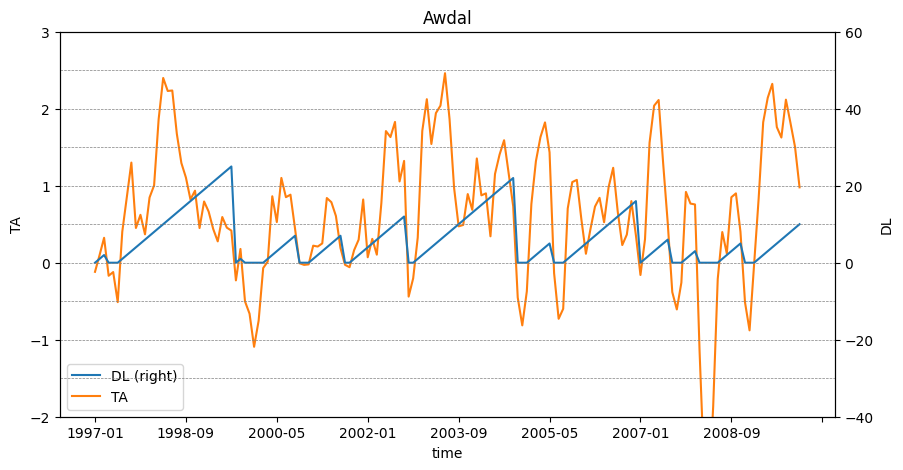

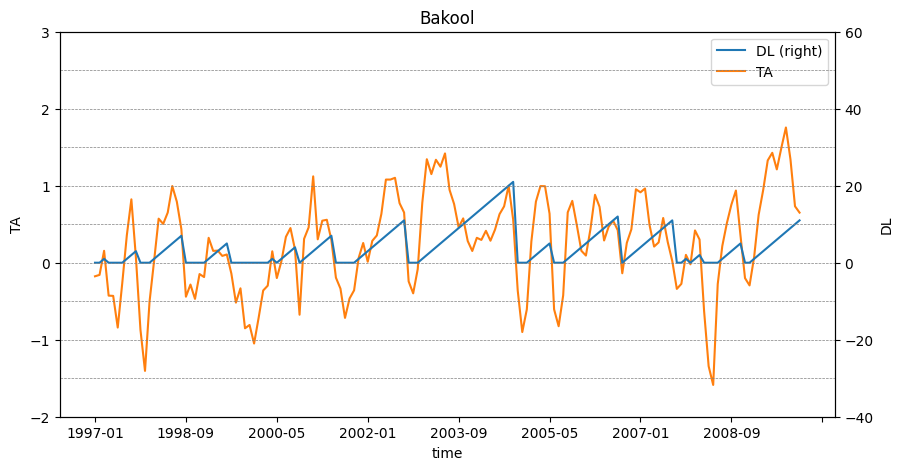

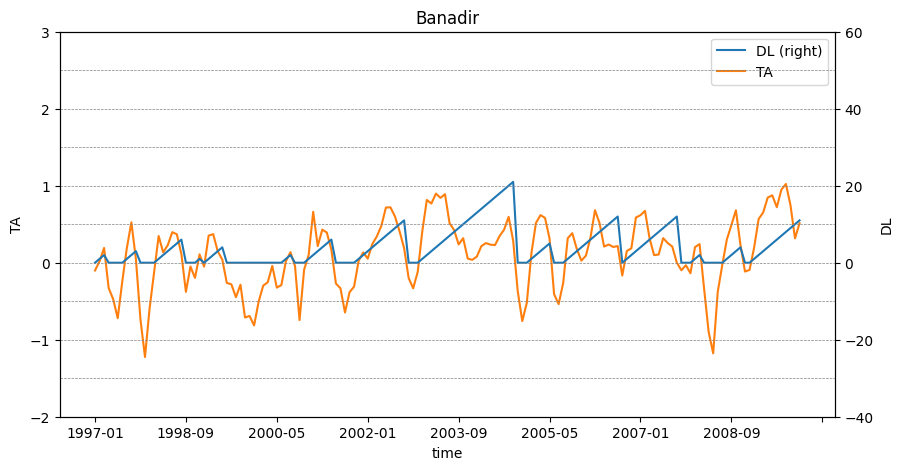

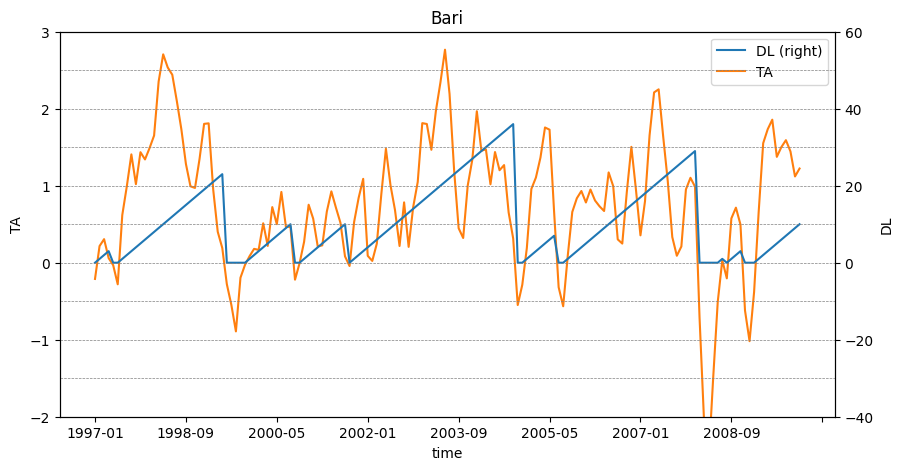

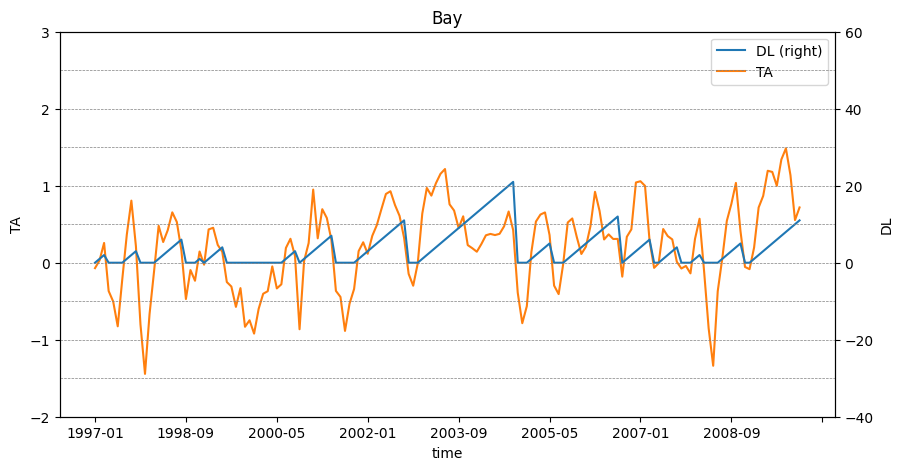

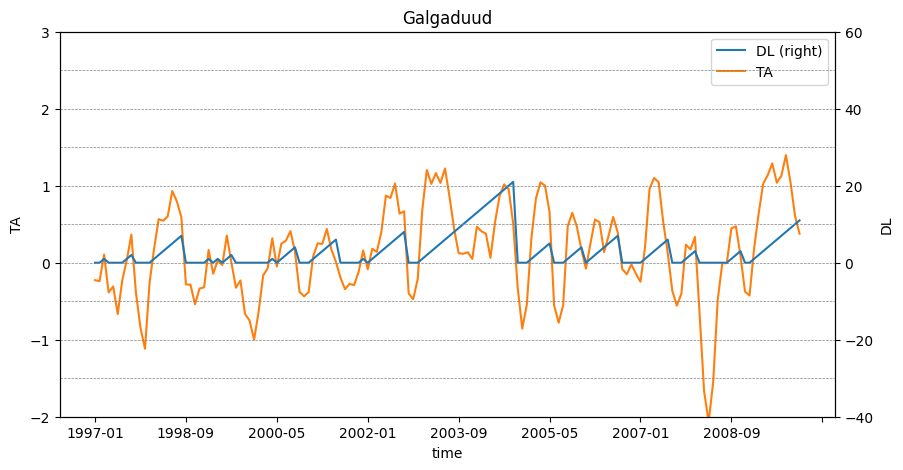

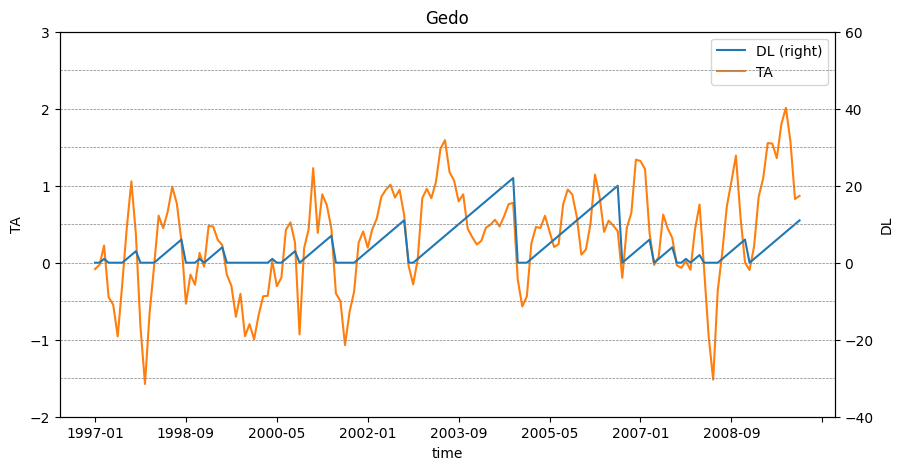

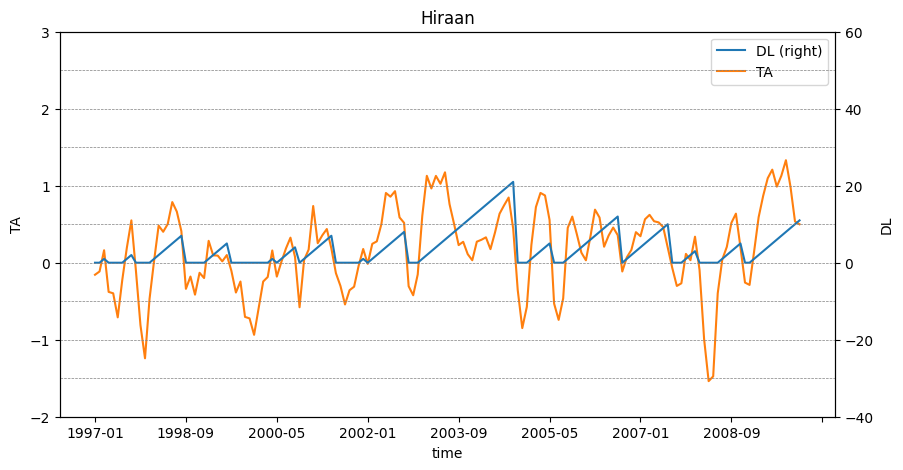

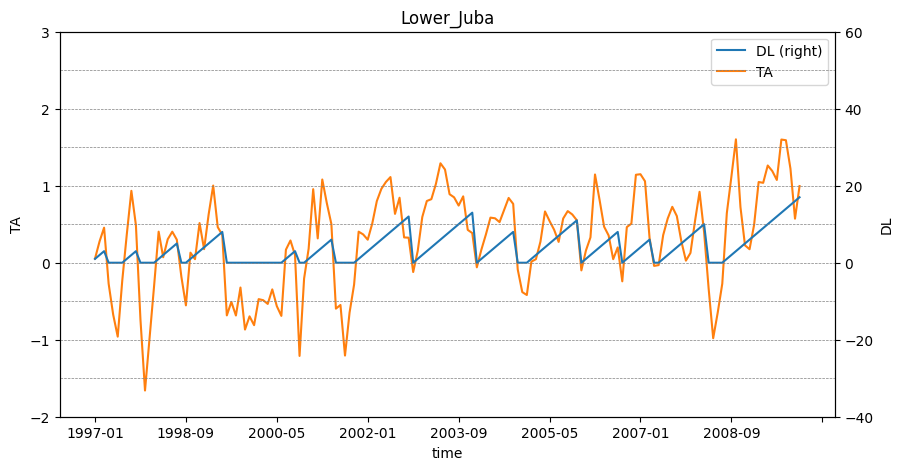

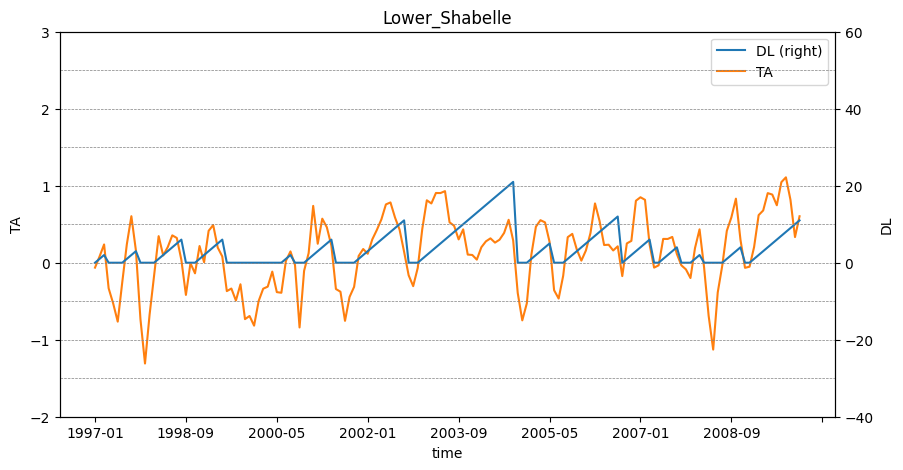

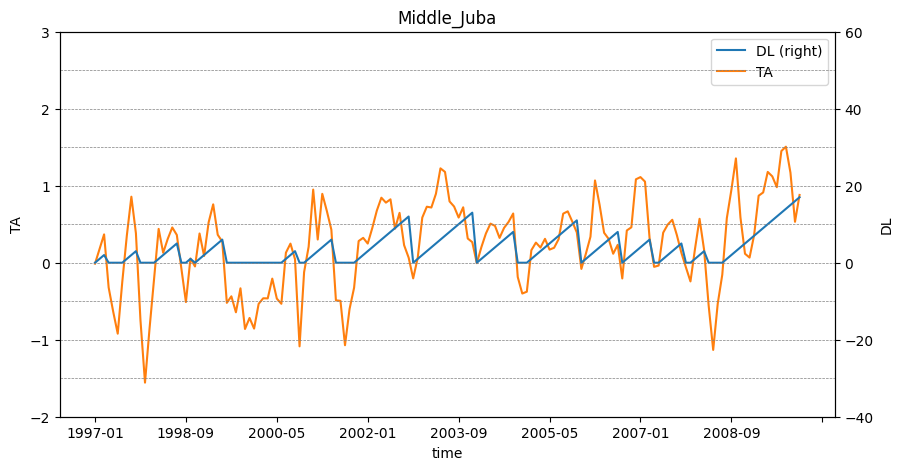

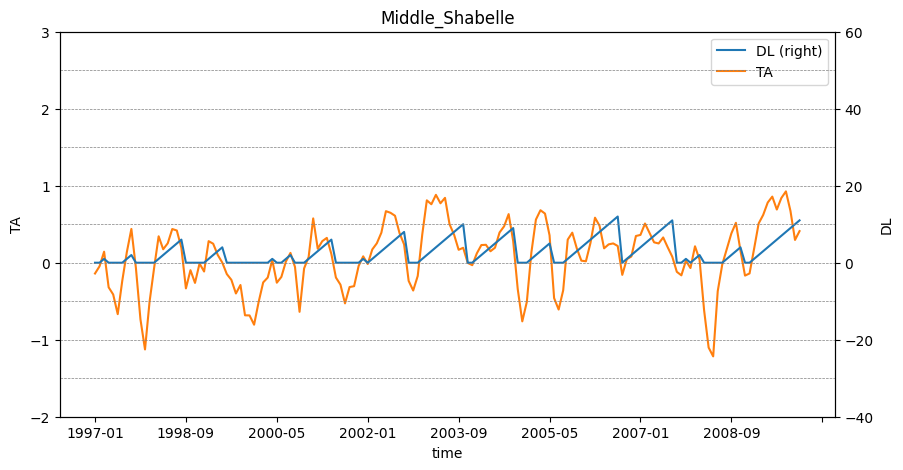

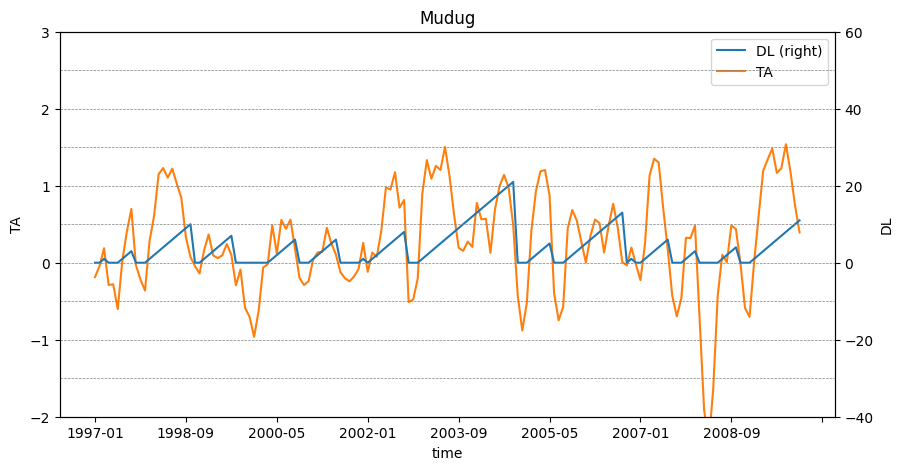

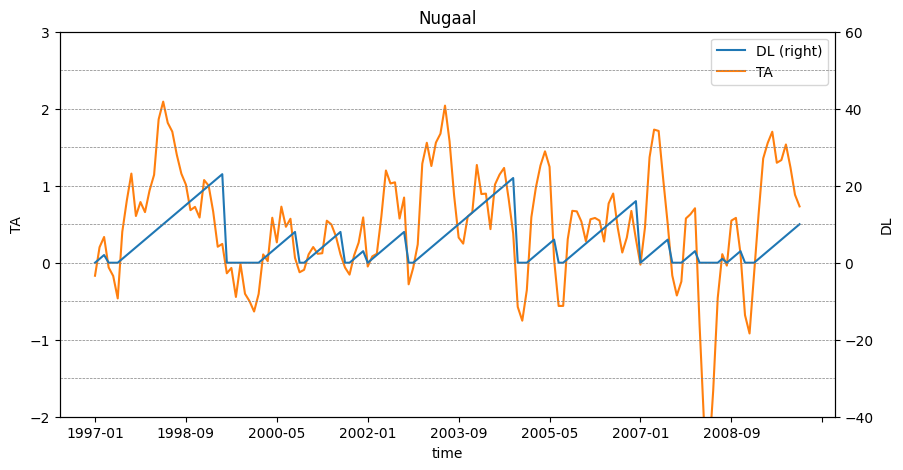

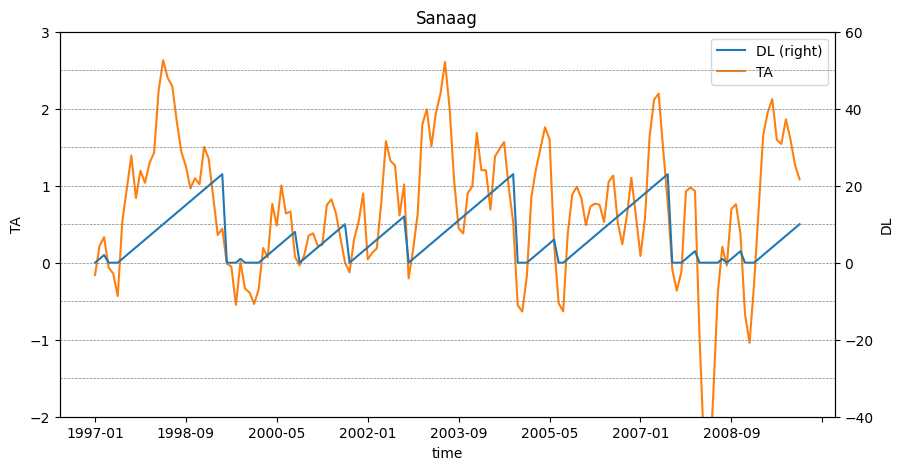

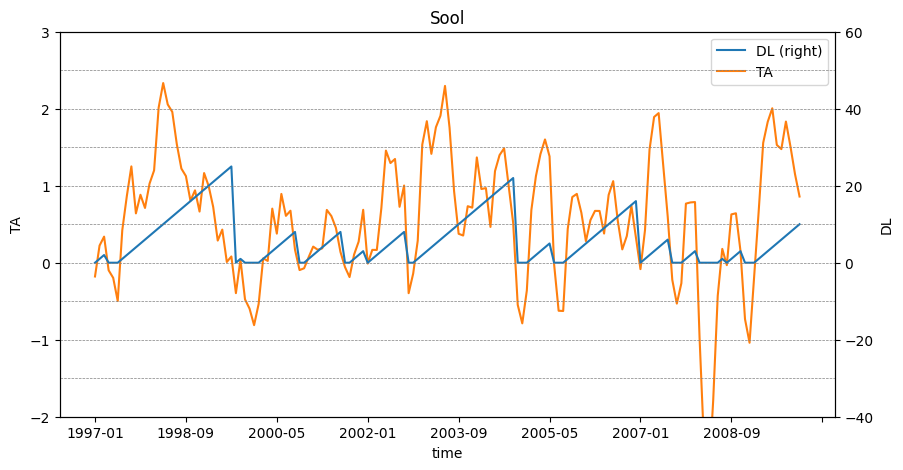

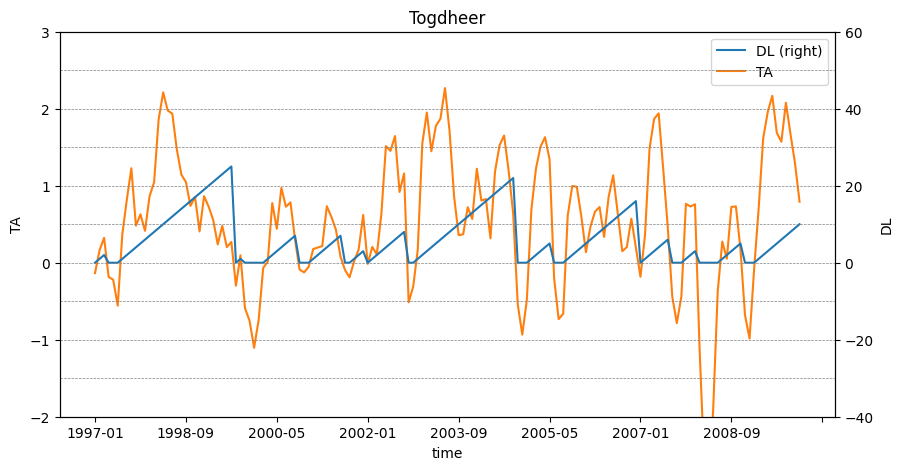

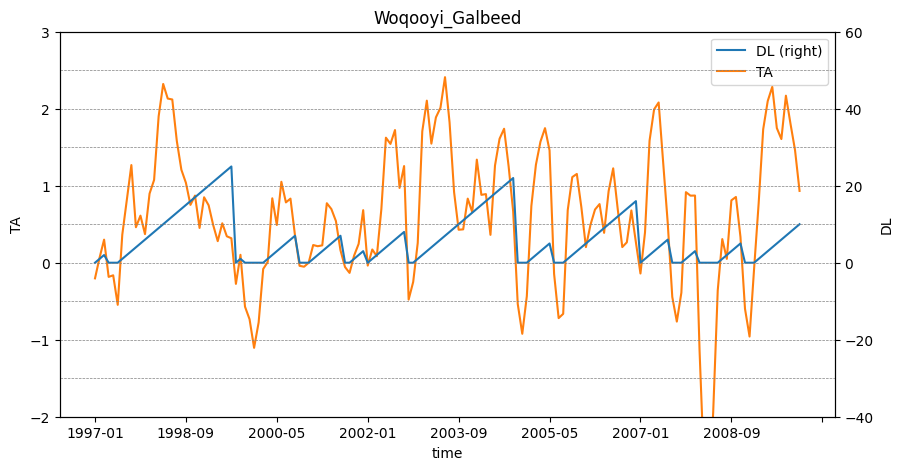

In [35]:
# plot variables DL and TA against time

for reg in df_c_97_09['admin1'].unique():
    aw = df_c_97_09[df_c_97_09['admin1']==reg]
    aw = aw[['time','DL','TA']]
    aw = aw.set_index('time')

    ax = aw.plot(secondary_y='DL', mark_right=True, figsize=(10,5))
    ax.set_ylabel('TA')
    ax.right_ax.set_ylabel('DL')
    ax.set_ylim(-2, 3)
    ax.right_ax.set_ylim(-40, 60)
    plt.title(reg)
    for i in range(-4, 6):
        plt.axhline(y=i*10, color='grey', linestyle='--', linewidth=0.5)